# Dimensionality Reduction and Visualization

In this notebook, we apply **t-SNE** and **UMAP** to reduce the dimensionality of the dataset, enabling us to visualize how cell lines are distributed in a 2D space based on their gene expression profiles (using PCA components).

These visualizations help us understand if cell lines cluster in a meaningful way and how the features relate to each other in lower dimensions.


In [11]:
import os
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap


In [12]:
# Load final dataset
final_data = pl.read_parquet("../../data/pseudo_bulk/gdsc_cell_drug_with_pca.parquet")


In [13]:
# Count NaNs in the full dataset
nan_counts = final_data.null_count()

print("🔍 NaN count per column:")
for col in final_data.columns:
    count = nan_counts[0, col]
    if count > 0:
        print(f"❗ {col}: {count}")
        
# Detect PC columns
pca_cols = [col for col in final_data.columns if col.startswith("PC")]

# NaNs in just PCA columns
pca_nulls = final_data.select(pca_cols).null_count()

print("\n🔬 NaNs in PCA columns:")
for col in pca_cols:
    count = pca_nulls[0, col]
    if count > 0:
        print(f"❗ {col}: {count}")

# Any row with at least one null in expression/PCA columns
rows_with_nan = final_data.filter(
    pl.any_horizontal([pl.col(col).is_null() for col in pca_cols])  # or gene_cols
)

print(f"\n⚠️ Total rows with missing values: {rows_with_nan.shape[0]}")
if rows_with_nan.shape[0] > 0:
    print("🔎 Sample rows with missing values:")
    print(rows_with_nan.head(5))
print("\n🧪 Unique cell lines with missing data:")
print(rows_with_nan.select("SANGER_MODEL_ID").unique())


🔍 NaN count per column:

🔬 NaNs in PCA columns:

⚠️ Total rows with missing values: 0

🧪 Unique cell lines with missing data:
shape: (0, 1)
┌─────────────────┐
│ SANGER_MODEL_ID │
│ ---             │
│ str             │
╞═════════════════╡
└─────────────────┘


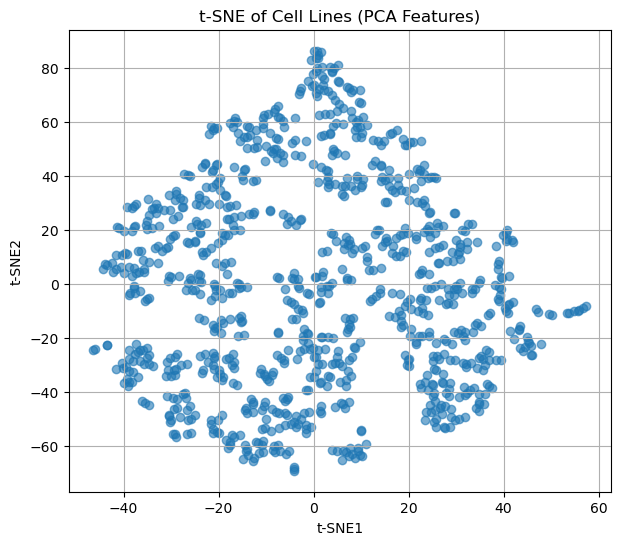

In [14]:
# Select only one row per cell line (expression is repeated per drug)
unique_cells = final_data.unique(subset=["SANGER_MODEL_ID"])

# Convert to pandas and set index
pca_df = unique_cells.to_pandas().set_index("SANGER_MODEL_ID")

# Get PCA columns
pca_cols = [col for col in pca_df.columns if col.startswith("PC")]
X_pca = pca_df[pca_cols].values


# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=10)
X_tsne = tsne.fit_transform(X_pca)

# Plot t-SNE
plt.figure(figsize=(7, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.6)
plt.title("t-SNE of Cell Lines (PCA Features)")
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.grid(True)
plt.savefig("statistics/tsne_visualization.png")
plt.show()
plt.close()


/home/guests3/gba/.conda/envs/tese-env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


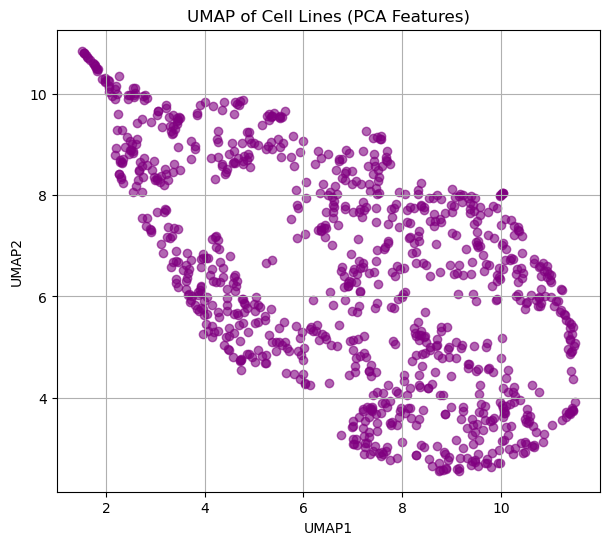

In [15]:
# UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_pca)

# Plot UMAP
plt.figure(figsize=(7, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], alpha=0.6, color="purple")
plt.title("UMAP of Cell Lines (PCA Features)")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.grid(True)
plt.savefig("statistics/umap_visualization.png")
plt.show()
plt.close()


### Conclusion

We applied **t-SNE** and **UMAP** to reduce the dimensionality of the dataset and visualize how cell lines are distributed based on their PCA features. The visualizations help identify potential clustering patterns and relationships between cell lines.

- **Next Steps**: Move on to baseline model evaluation to assess the performance of simple regression models.
